In [1]:
import sys
sys.path.append("..")  # Adds the parent directory to the sys.path

from sklearn.mixture import GaussianMixture
from hough_circle_trafo import hough_circle
from utitlity_functions import *
import numpy as np
from confectionery import Confectionery
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from background_subtraction_gmm import Backsub as Backsub
from sklearn.cluster import KMeans
from cluster_half_shelfs_alpha import Half_shelf_cluster
import scienceplots
import cv2 as cv
from matplotlib import cm
from segmentation import Segmentation as Segmentation
from PIL import Image, ImageDraw
import networkx as nx
from networkx.algorithms import bipartite
from scipy.stats import norm
np.random.seed(137)

# Example of plot

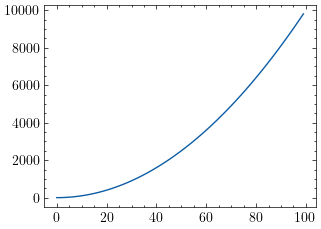

In [2]:
plt.style.use('science')
x=np.arange(100)
y=x**2
with plt.style.context('science'):
    plt.figure()
    plt.plot(x, y)
    plt.show()

# Load Image

In [3]:
start_frame=0
end_frame=987
stream_string=[]
for i in range(start_frame,end_frame+1):
    im_path="/Users/Hoang_1/Desktop/Master_Arbeit/software/janus_particle_tracking/Image_Data/Aufnahmen_JPEG_06_07_take_2/Hoang_07_06_2023_Aufnahmen_Rollen_Partikel_Rollen_12_mu_200_002_t"+str(i).zfill(3)+".jpg"
    stream_string.append(im_path)
obj_0=my_data = np.genfromtxt('/Users/Hoang_1/Desktop/Master_Arbeit/software/janus_particle_tracking/object_0_trajectory.csv', delimiter=',')
obj_0=obj_0[1:,:]

frame_number=172
im=cv.imread(cv.samples.findFile(stream_string[frame_number]), cv.IMREAD_GRAYSCALE)
obj=obj_0[frame_number,1:]
x=obj[0]
y=obj[1]
r=obj[2]
a=10
object_indeces=np.s_[-a+round(y-round(r)):round(y+round(r))+1+a,
                     -a+round(x-round(r)):round(x+round(r))+1+a]
im_obj=im[object_indeces]

# Display segmented object image

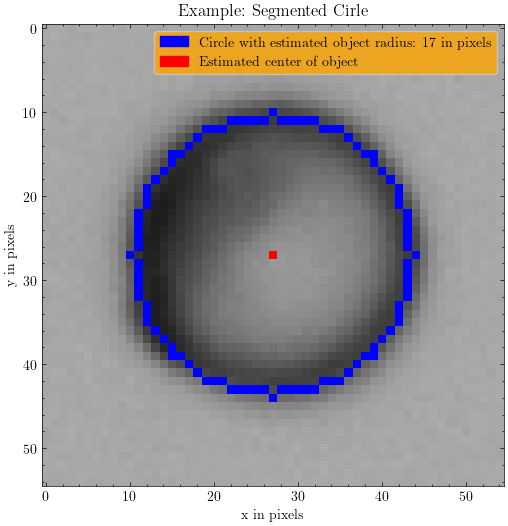

In [4]:
im_bgr=cv.cvtColor(im_obj,cv.COLOR_GRAY2BGR)
center=((im_bgr.shape[0]-1)//2, (im_bgr.shape[0]-1)//2)
im_bgr[center[0],center[0],:]=np.array([255,0,0])
cv.circle(im_bgr, center, round(r), (0,0,255), 1)
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [6, 6]
    ax=plt.figure()
    plt.title("Example: Segmented Cirle")
    plt.xlabel("x in pixels")
    plt.ylabel("y in pixels")
    plt.imshow(im_bgr,cmap="gray")
    blue_patch = mpatches.Patch(color='blue', label='Circle with estimated object radius: '+str(round(r)) + ' in pixels')
    red_patch = mpatches.Patch(color='red', label='Estimated center of object')
    plt.legend(handles=[blue_patch, red_patch],frameon=True, facecolor="orange")
    plt.show()

# Clustering within whole circle

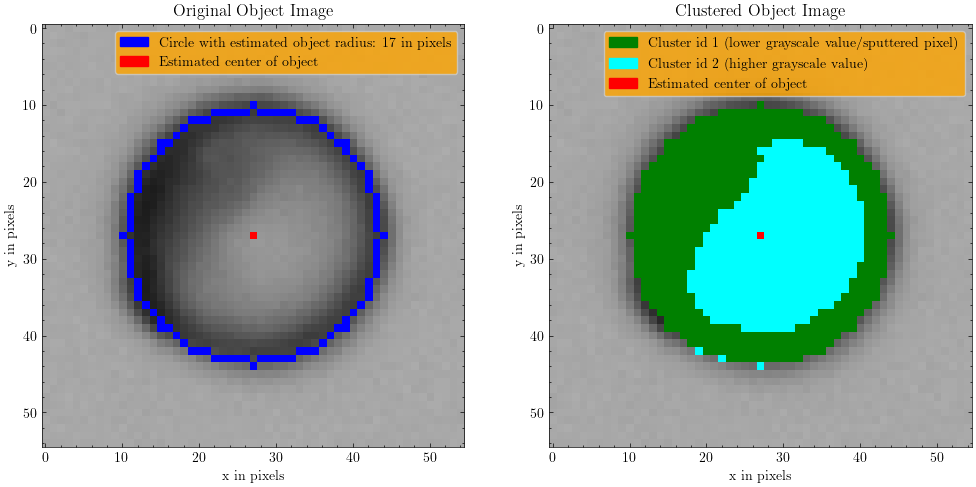

In [5]:
koppenrath=Confectionery()
blue_vector=np.array([0,0,255],dtype=np.uint8).reshape((1,1,3))
green_vector=np.array([0,128,0],dtype=np.uint8).reshape((1,1,3))
cyan_vector=np.array([0,255,255],dtype=np.uint8).reshape((1,1,3))
red_vector=np.array([255,0,0]).reshape((1,1,3))
M=koppenrath.sell_cake(round(r),im_obj.shape[0],im_obj.shape[1])
X=im_obj[M]

X=X.reshape((-1,1))
K=2
kmeans = KMeans(n_clusters=K, random_state=0, n_init="auto").fit(X)
labels=kmeans.labels_.reshape((-1))
means=kmeans.cluster_centers_.reshape((-1))
# sort labels and means
idx = np.argsort(means)
means=means[idx]
labels=idx[labels]

im_clustered=np.zeros(im_obj.shape,np.uint8)
im_clustered[M==1]=(labels+1).reshape(-1)
a1=(im_clustered==1).reshape(-1)
a2=(im_clustered==2).reshape(-1)

im_clustered=np.copy(im_bgr)
b=np.arange(a1.size)
c=b[a1]
index=np.unravel_index(c,(im_obj.shape))
im_clustered[index[0],index[1],:]=green_vector
b=np.arange(a1.size)
c=b[a2]
index=np.unravel_index(c,(im_obj.shape))
im_clustered[index[0],index[1],:]=cyan_vector
im_clustered[(im_clustered.shape[0]-1)//2,(im_clustered.shape[0]-1)//2,:]=red_vector
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [12, 12]
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.set_title('Original Object Image')
    ax1.imshow(im_bgr, cmap="gray")
    ax1.set_xlabel("x in pixels")
    ax1.set_ylabel("y in pixels")
    ax2.set_title('Clustered Object Image')
    ax2.imshow(im_clustered, cmap="gray")
    ax2.set_xlabel("x in pixels")
    ax2.set_ylabel("y in pixels")
    blue_patch = mpatches.Patch(color='blue', label='Circle with estimated object radius: '+str(round(r)) + ' in pixels')
    green_patch = mpatches.Patch(color='green', label='Cluster id 1 (lower grayscale value/sputtered pixel)')
    cyan_patch = mpatches.Patch(color='cyan', label='Cluster id 2 (higher grayscale value)')
    red_patch = mpatches.Patch(color='red', label='Estimated center of object')
    ax1.legend(handles=[blue_patch, red_patch],frameon=True, facecolor="orange")
    ax2.legend(handles=[green_patch, cyan_patch, red_patch],frameon=True, facecolor="orange")
    plt.show()
im_clustered_1=im_clustered

#  Clustering within effective radius

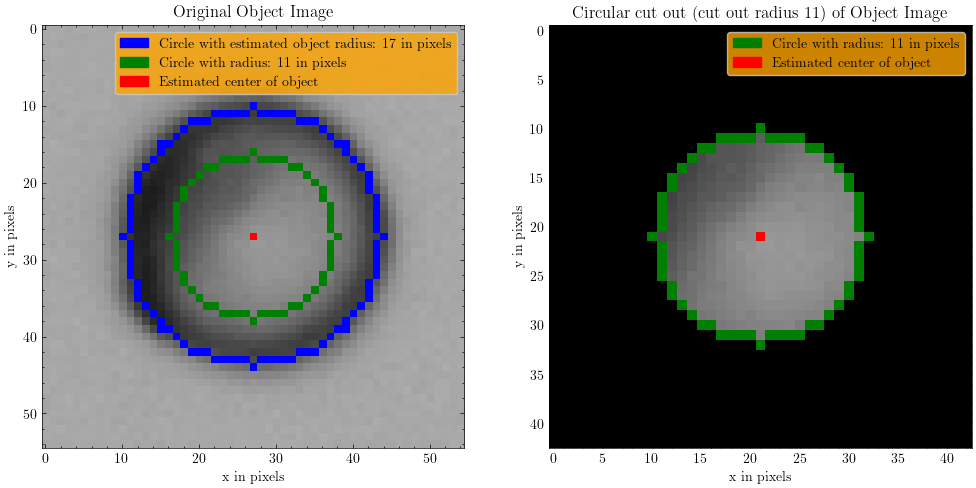

In [6]:
r_effective=11

cv.circle(im_bgr, center, r_effective, (0,128,0), 1)

im_effective=np.zeros_like(im_obj)
M=koppenrath.sell_cake(r_effective,im_obj.shape[0],im_obj.shape[1])
im_effective[M]=im_obj[M]
a=round(r)-r_effective
im_effective=im_effective[a:-a,a:-a]
im_effective_bgr=cv.cvtColor(im_effective,cv.COLOR_GRAY2BGR)
center=((im_effective_bgr.shape[0]-1)//2,(im_effective_bgr.shape[0]-1)//2)
cv.circle(im_effective_bgr, center, r_effective, (0,128,0), 1)
im_effective_bgr[center[0],center[0],:]=red_vector

with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [12, 12]
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.set_title('Original Object Image')
    ax1.imshow(im_bgr, cmap="gray")
    ax1.set_xlabel("x in pixels")
    ax1.set_ylabel("y in pixels")
    ax2.set_title("Circular cut out (cut out radius " +str(r_effective)+") of Object Image")
    ax2.imshow(im_effective_bgr, cmap="gray")
    ax2.set_xlabel("x in pixels")
    ax2.set_ylabel("y in pixels")
    blue_patch = mpatches.Patch(color='blue', label='Circle with estimated object radius: '+str(round(r)) + ' in pixels')
    green_patch = mpatches.Patch(color='green', label='Circle with radius: '+str(round(r_effective)) + ' in pixels')
    red_patch = mpatches.Patch(color='red', label='Estimated center of object')
    ax1.legend(handles=[blue_patch, green_patch, red_patch],frameon=True, facecolor="orange")
    ax2.legend(handles=[green_patch, red_patch],frameon=True, facecolor="orange")
    plt.show()

im_bgr_original=im_bgr

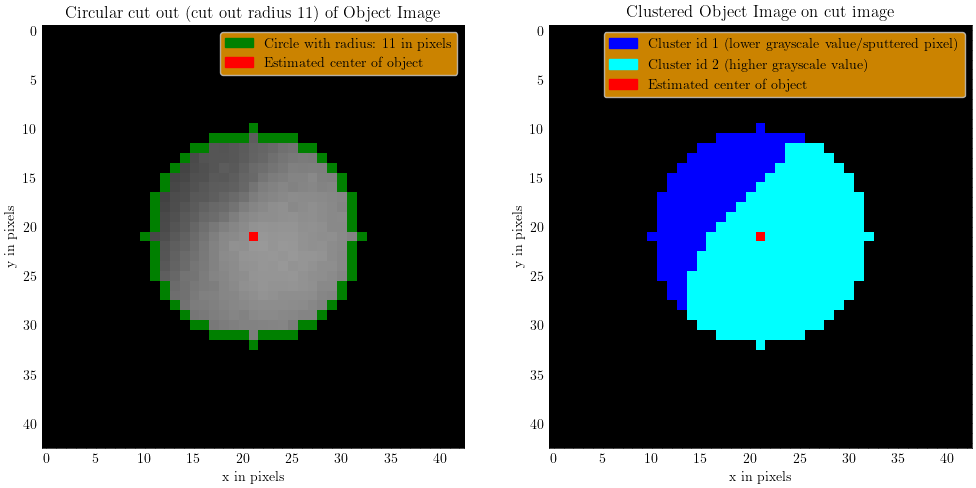

In [7]:
M=koppenrath.sell_cake(r_effective,im_effective.shape[0],im_effective.shape[1])
X=im_effective[M]

X=X.reshape((-1,1))
K=2
kmeans = KMeans(n_clusters=K, random_state=0, n_init="auto").fit(X)
labels=kmeans.labels_.reshape((-1))
means=kmeans.cluster_centers_.reshape((-1))
# sort labels and means
idx = np.argsort(means)
means=means[idx]
labels=idx[labels]

im_clustered=np.zeros(im_effective.shape,np.uint8)
im_clustered[M==1]=(labels+1).reshape(-1)
a1=(im_clustered==1).reshape(-1)
a2=(im_clustered==2).reshape(-1)

im_clustered=np.copy(im_effective_bgr)
b=np.arange(a1.size)
c=b[a1]
index=np.unravel_index(c,(im_effective.shape))
im_clustered[index[0],index[1],:]=blue_vector
b=np.arange(a1.size)
c=b[a2]
index=np.unravel_index(c,(im_effective.shape))
im_clustered[index[0],index[1],:]=cyan_vector
im_clustered[(im_clustered.shape[0]-1)//2,(im_clustered.shape[0]-1)//2,:]=red_vector
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [12, 12]
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.set_title("Circular cut out (cut out radius " +str(r_effective)+") of Object Image")
    ax1.imshow(im_effective_bgr, cmap="gray")
    ax1.set_xlabel("x in pixels")
    ax1.set_ylabel("y in pixels")
    ax2.set_title('Clustered Object Image on cut image')
    ax2.imshow(im_clustered, cmap="gray")
    ax2.set_xlabel("x in pixels")
    ax2.set_ylabel("y in pixels")
    blue_patch = mpatches.Patch(color='blue', label='Cluster id 1 (lower grayscale value/sputtered pixel)')
    green_patch = mpatches.Patch(color='green', label='Circle with radius: '+str(r_effective) + ' in pixels')
    cyan_patch = mpatches.Patch(color='cyan', label='Cluster id 2 (higher grayscale value)')
    red_patch = mpatches.Patch(color='red', label='Estimated center of object')
    ax1.legend(handles=[green_patch, red_patch],frameon=True, facecolor="orange")
    ax2.legend(handles=[blue_patch, cyan_patch, red_patch],frameon=True, facecolor="orange")
    plt.show()
im_clustered_2=im_clustered

# Clustering with GMM

In [8]:

start_frame=150
frame_step=30
end_frame=start_frame+5*frame_step
frames=np.arange(start_frame, end_frame,frame_step)

objects=obj_0[frames,1:]
a=10
object_indeces=[np.s_[-a+round(o[1]-round(o[2])):round(o[1]+round(o[2]))+1+a,
                     -a+round(o[0]-round(o[2])):round(o[0]+round(o[2]))+1+a] for o in objects]
im_obj=[cv.imread(cv.samples.findFile(stream_string[frame_number]), cv.IMREAD_GRAYSCALE) for frame_number in frames]

In [9]:
im_obj_bgr=[]
im_obj_bgr_original=[]
X=[]
for k in range(len(im_obj)):
    im_obj[k]=im_obj[k][object_indeces[k]]
    M=koppenrath.sell_cake(r_effective,im_obj[k].shape[0],im_obj[k].shape[0])
    X.append(im_obj[k][M])
    im_bgr=cv.cvtColor(im_obj[k],cv.COLOR_GRAY2BGR)
    im_obj_bgr_original.append(np.copy(im_bgr))
    center=((im_bgr.shape[0]-1)//2,(im_bgr.shape[0]-1)//2)
    cv.circle(im_bgr, center, r_effective, (0,128,0), 1)
    im_obj_bgr.append(im_bgr)
x_max=max([max(d) for d in X])
x_min=min([min(d) for d in X])

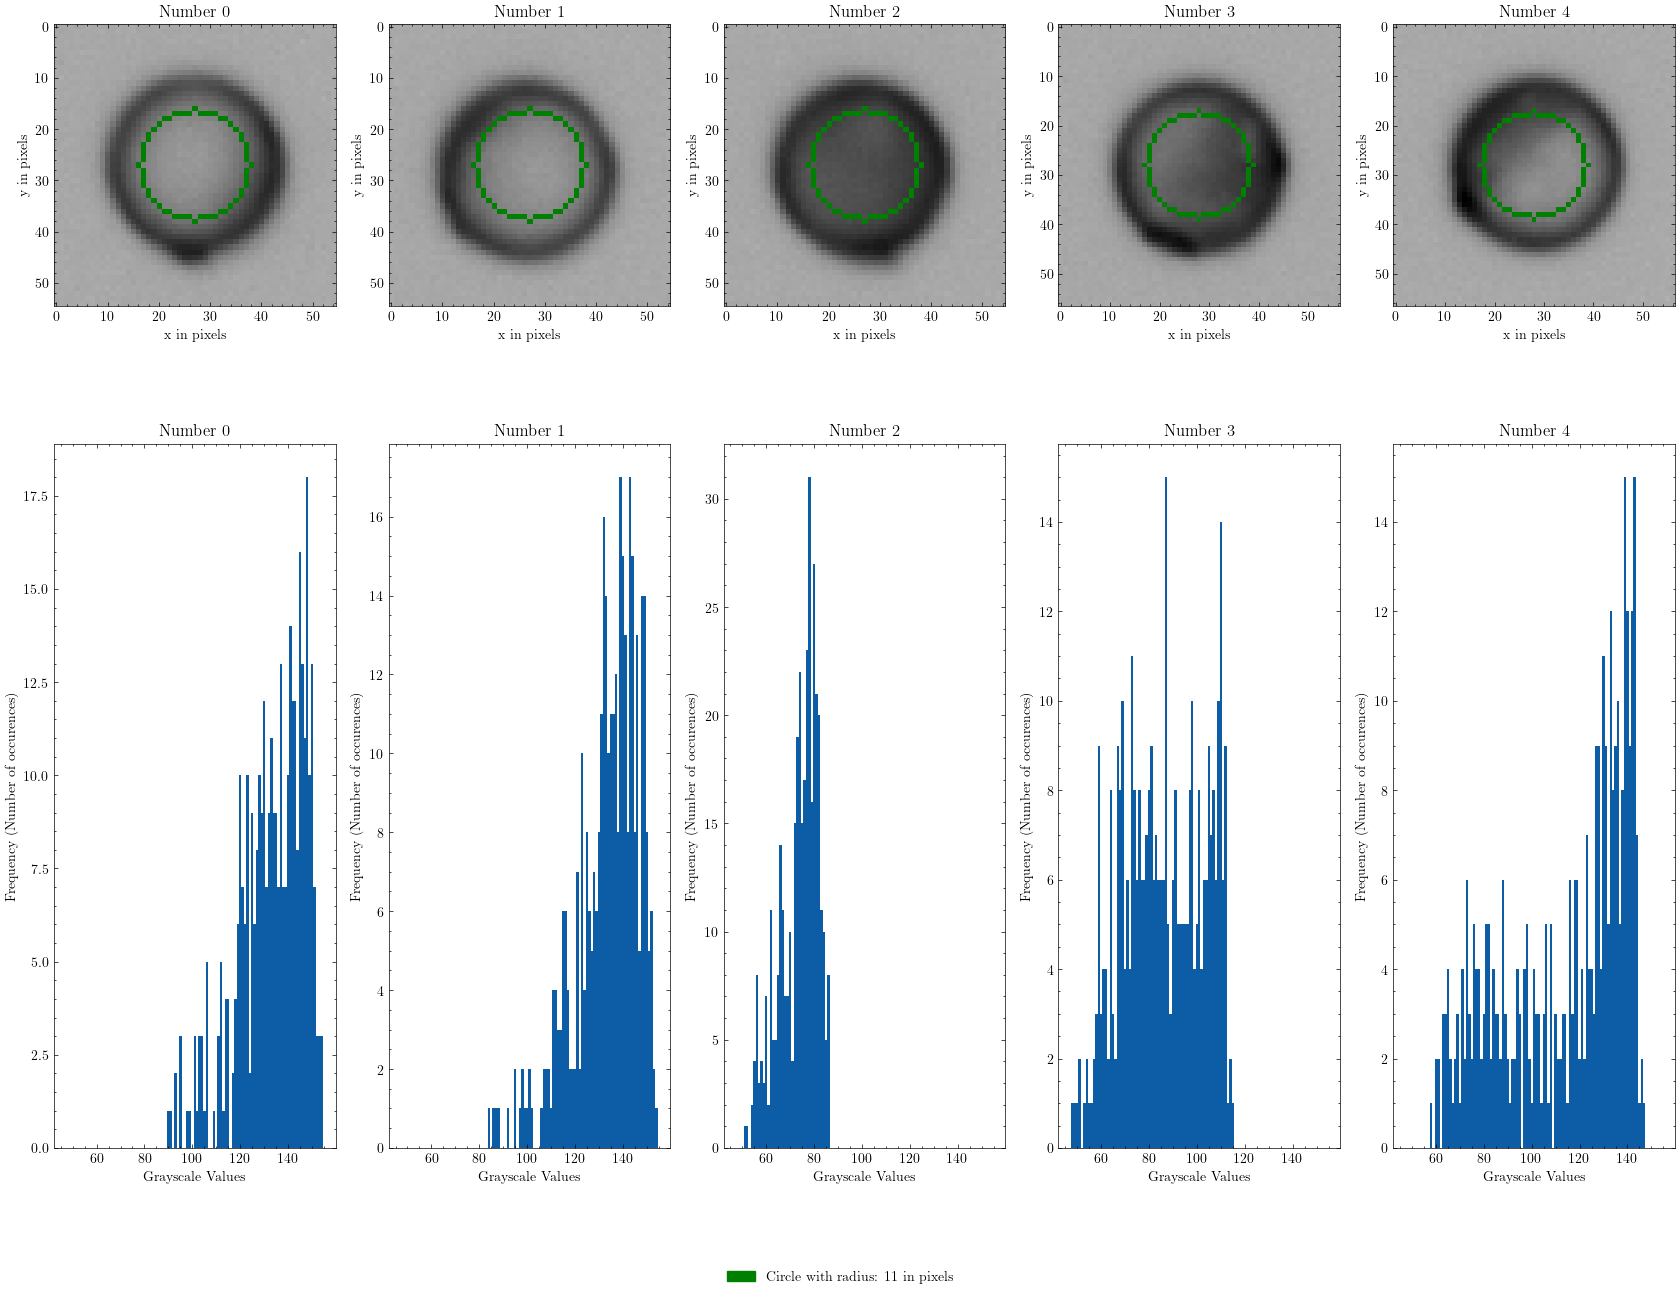

In [10]:
bins=np.arange(x_min,x_max+1)-0.5
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [17, 15]
    fig, ax = plt.subplots(2,len(im_obj))
    for k in range(len(im_obj)):
        ax[0,k].set_title("Number " +str(k))
        ax[0,k].imshow(im_obj_bgr[k], cmap="gray")
        ax[0,k].set_xlabel("x in pixels")
        ax[0,k].set_ylabel("y in pixels")
    for k in range(len(im_obj)):
        ax[1,k].set_title("Number " +str(k))
        ax[1,k].hist(X[k], bins=bins)
        ax[1,k].set_xlabel("Grayscale Values")
        ax[1,k].set_ylabel("Frequency (Number of occurences)")
    blue_patch = mpatches.Patch(color='blue', label='Cluster id 1 (lower grayscale value/sputtered pixel)')
    green_patch = mpatches.Patch(color='green', label='Circle with radius: '+str(r_effective) + ' in pixels')
    cyan_patch = mpatches.Patch(color='cyan', label='Cluster id 2 (higher grayscale value)')
    red_patch = mpatches.Patch(color='red', label='Estimated center of object')
    fig.tight_layout() 
    fig.subplots_adjust(bottom=0.1)   ##  Need to play with this number.
    fig.legend(handles=[green_patch], loc="lower center", ncol=4)
    plt.show()


In [11]:
half_shelf_cluster=Half_shelf_cluster(obj_0, stream_string, confectionery=koppenrath,cut_radius=r_effective)
half_shelf_cluster.load_data_initial(frame_portion=1.0)


987

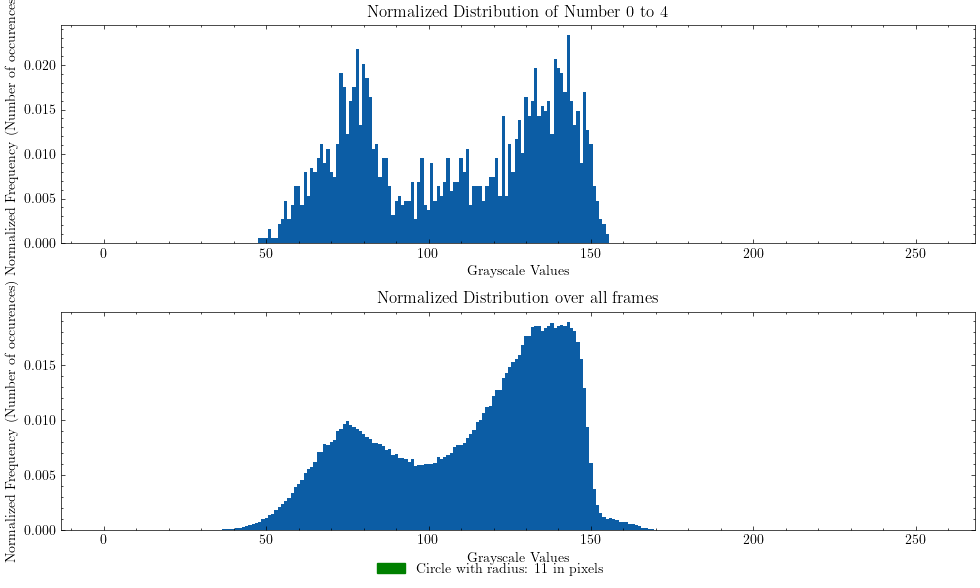

In [12]:
X_total=np.array(X)
X_total=X_total.reshape((-1))
X_all=half_shelf_cluster.data
bins=np.arange(257)-0.5
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [10, 6]
    fig, ax = plt.subplots(2,1)
    ax[0].set_title("Normalized Distribution of Number 0 to 4")
    ax[0].hist(X_total, bins=bins, density=True)
    ax[0].set_xlabel("Grayscale Values")
    ax[0].set_ylabel("Normalized Frequency (Number of occurences)")
    ax[1].set_title("Normalized Distribution over all frames")
    ax[1].hist(X_all, bins=bins, density=True)
    ax[1].set_xlabel("Grayscale Values")
    ax[1].set_ylabel("Normalized Frequency (Number of occurences)")
    fig.tight_layout() 
    fig.subplots_adjust(bottom=0.1)   ##  Need to play with this number.
    fig.legend(handles=[green_patch], loc="lower center", ncol=4)
    plt.show()


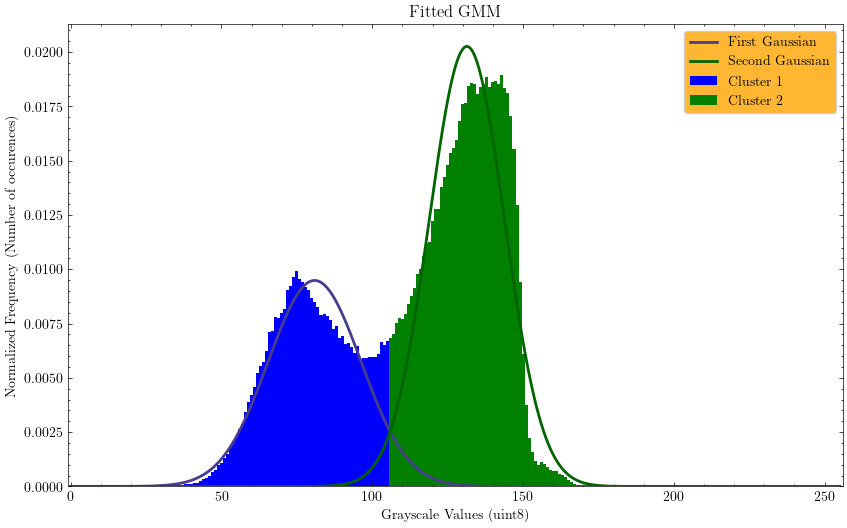

In [13]:
gmm = GaussianMixture(n_components=2, random_state=0).fit(X_all.reshape((-1,1)))
t = np.linspace(0,255, 1000)
labels_gmm = gmm.fit_predict(X_all.reshape((-1,1)))
priors_gmm = gmm.weights_
means_gmm = gmm.means_.reshape((-1))
sigma_gmm = np.sqrt(gmm.covariances_.reshape((-1)))
# sort gaussian
idx = np.argsort(means_gmm)
means_gmm=means_gmm[idx]
priors_gmm=priors_gmm[idx]
sigma_gmm=sigma_gmm[idx]
labels_gmm=idx[labels_gmm]
Y1=X_all[labels_gmm==0]
Y2=X_all[labels_gmm==1]
colors = ['blue', 'green',]
labels = ['Cluster 1','Cluster 2']
with plt.style.context('science'):
    x = np.linspace(0,255, 1000)
    plt.rcParams['figure.figsize'] = [10, 6]
    ax=plt.figure()
    plt.title("Fitted GMM")
    hist1, _ = np.histogram(Y1, bins=bins)
    hist1 = hist1/X_all.size
    hist2, _ = np.histogram(Y2, bins=bins)
    hist2 = hist2/X_all.size
    plt.bar(np.arange(0,256), hist1, width = 1, align = 'center', color=colors[0], label=labels[0])
    plt.bar(np.arange(0,256), hist2, width = 1, align = 'center', color=colors[1], label=labels[1])
    plt.plot(t, priors_gmm[0]*norm.pdf(t, means_gmm[0], sigma_gmm[0]),label="First Gaussian", color="darkslateblue", linewidth=2)
    plt.plot(t, priors_gmm[1]*norm.pdf(t, means_gmm[1], sigma_gmm[1]),label="Second Gaussian", color="darkgreen", linewidth=2)
    plt.xlabel("Grayscale Values (uint8)")
    plt.ylabel("Normalized Frequency (Number of occurences)")
    plt.legend(frameon=True, facecolor="orange")
    plt.xlim(-1, 256)
    plt.show()

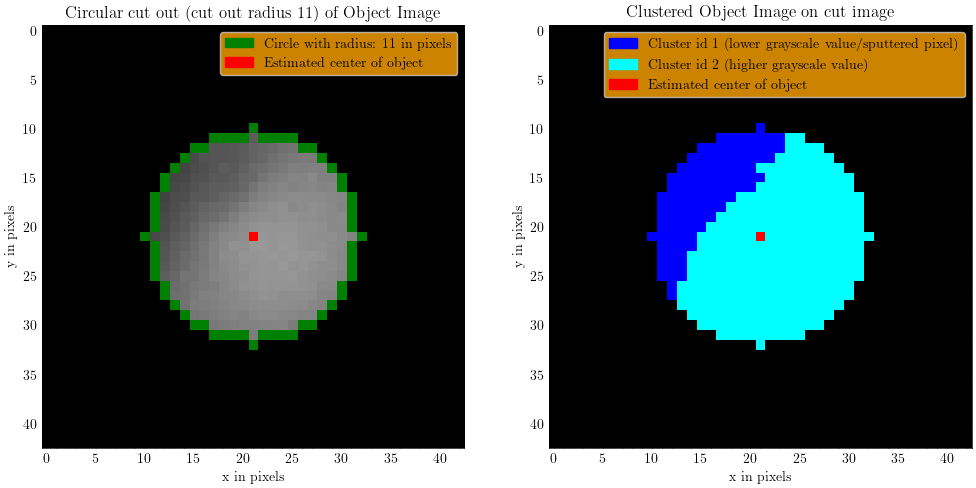

In [14]:
M=koppenrath.sell_cake(r_effective,im_effective.shape[0],im_effective.shape[1])
X=im_effective[M]
X=X.reshape((-1,1))
labels=gmm.predict(X)
labels=idx[labels]
im_clustered=np.zeros(im_effective.shape,np.uint8)
im_clustered[M==1]=(labels+1).reshape(-1)
a1=(im_clustered==1).reshape(-1)
a2=(im_clustered==2).reshape(-1)
im_clustered=np.copy(im_effective_bgr)
b=np.arange(a1.size)
c=b[a1]
index=np.unravel_index(c,(im_effective.shape))
im_clustered[index[0],index[1],:]=blue_vector
b=np.arange(a1.size)
c=b[a2]
index=np.unravel_index(c,(im_effective.shape))
im_clustered[index[0],index[1],:]=cyan_vector
im_clustered[(im_clustered.shape[0]-1)//2,(im_clustered.shape[0]-1)//2,:]=red_vector
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [12, 10]
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.set_title("Circular cut out (cut out radius " +str(r_effective)+") of Object Image")
    ax1.imshow(im_effective_bgr, cmap="gray")
    ax1.set_xlabel("x in pixels")
    ax1.set_ylabel("y in pixels")
    ax2.set_title('Clustered Object Image on cut image')
    ax2.imshow(im_clustered, cmap="gray")
    ax2.set_xlabel("x in pixels")
    ax2.set_ylabel("y in pixels")
    blue_patch = mpatches.Patch(color='blue', label='Cluster id 1 (lower grayscale value/sputtered pixel)')
    green_patch = mpatches.Patch(color='green', label='Circle with radius: '+str(r_effective) + ' in pixels')
    cyan_patch = mpatches.Patch(color='cyan', label='Cluster id 2 (higher grayscale value)')
    red_patch = mpatches.Patch(color='red', label='Estimated center of object')
    ax1.legend(handles=[green_patch, red_patch],frameon=True, facecolor="orange")
    ax2.legend(handles=[blue_patch, cyan_patch, red_patch],loc="upper right" ,frameon=True, facecolor="orange")
    plt.show()
im_clustered_3=im_clustered

# Clustered Methods comparison

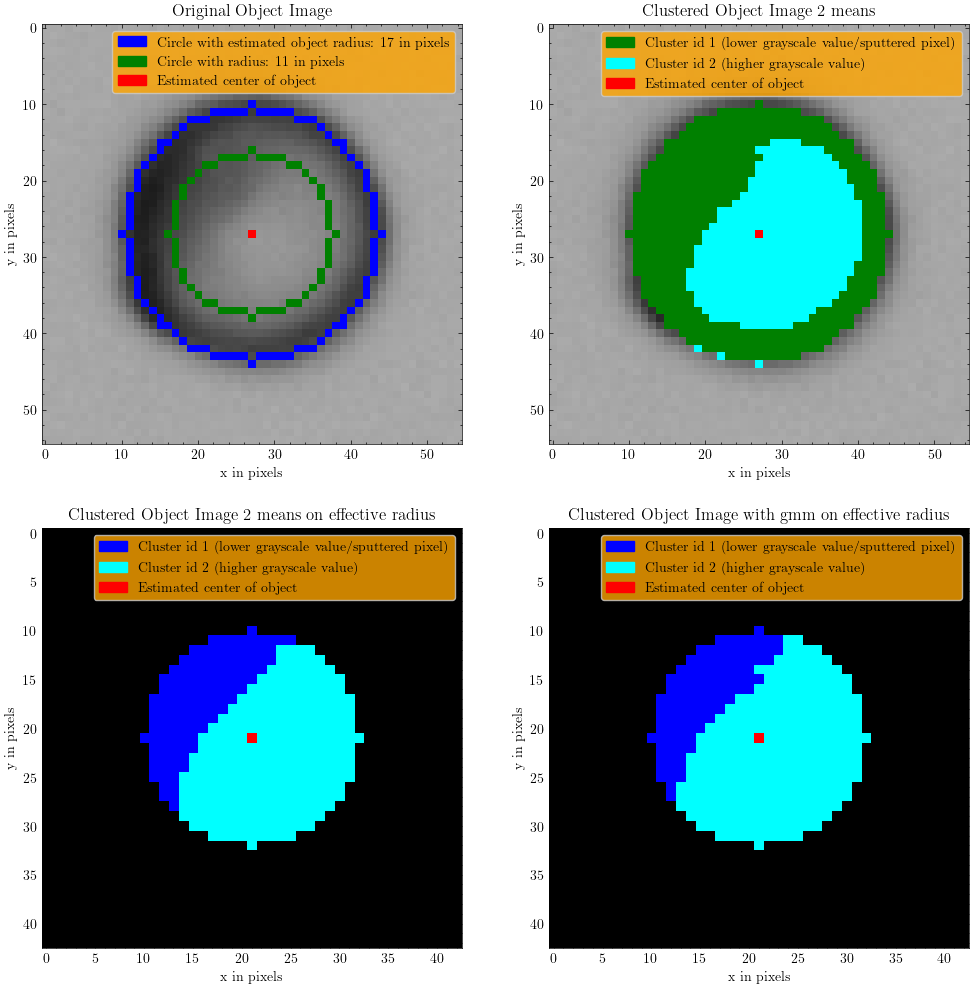

In [15]:
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [12, 12]
    fig, ax = plt.subplots(2,2)
    ax[0,0].set_title('Original Object Image')
    ax[0,0].imshow(im_bgr_original, cmap="gray")
    ax[0,0].set_xlabel("x in pixels")
    ax[0,0].set_ylabel("y in pixels")

    ax[0,1].set_title('Clustered Object Image 2 means')
    ax[0,1].imshow(im_clustered_1, cmap="gray")
    ax[0,1].set_xlabel("x in pixels")
    ax[0,1].set_ylabel("y in pixels")

    ax[1,0].set_title('Clustered Object Image 2 means on effective radius')
    ax[1,0].imshow(im_clustered_2, cmap="gray")
    ax[1,0].set_xlabel("x in pixels")
    ax[1,0].set_ylabel("y in pixels")

    ax[1,1].set_title('Clustered Object Image with gmm on effective radius')
    ax[1,1].imshow(im_clustered_3, cmap="gray")
    ax[1,1].set_xlabel("x in pixels")
    ax[1,1].set_ylabel("y in pixels")

    blue_patch = mpatches.Patch(color='blue', label='Circle with estimated object radius: '+str(round(r)) + ' in pixels')
    green_patch = mpatches.Patch(color='green', label='Circle with radius: '+str(round(r_effective)) + ' in pixels')
    red_patch = mpatches.Patch(color='red', label='Estimated center of object')
    ax[0,0].legend(handles=[blue_patch, green_patch, red_patch],frameon=True, facecolor="orange")
    green_patch = mpatches.Patch(color='green', label='Cluster id 1 (lower grayscale value/sputtered pixel)')
    cyan_patch = mpatches.Patch(color='cyan', label='Cluster id 2 (higher grayscale value)')
    ax[0,1].legend(handles=[green_patch, cyan_patch, red_patch],frameon=True, facecolor="orange")
    blue_patch = mpatches.Patch(color='blue', label='Cluster id 1 (lower grayscale value/sputtered pixel)')
    cyan_patch = mpatches.Patch(color='cyan', label='Cluster id 2 (higher grayscale value)')
    ax[1,0].legend(handles=[blue_patch, cyan_patch, red_patch],frameon=True, facecolor="orange")
    ax[1,1].legend(handles=[blue_patch, cyan_patch, red_patch],loc="upper right" ,frameon=True, facecolor="orange")
    plt.show()
